In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete = load_umachine_sdss_with_meert15()
no_data_mask = np.isnan(full_sdss['Magr_tot_meert15'])

mask = ~no_data_mask & behroozi_complete
sdss = full_sdss[mask]
print(sdss.keys())
print("\nNumber of galaxies in complete sample = {0}".format(len(sdss)))

['ra', 'dec', 'z', 'bptclass', 'sm', 'sfr', 'specsfr', 'sm_fib', 'sfr_fib', 'specsfr_fib', 'withinr', 'eligiblehost', 'sm_complete', 'eligiblehost2', 'd4000', 'd4000_sub', 'd4000_n', 'd4000_n_sub', 'has_match', 'logM_mendel13', 'logMB_mendel13', 'logMD_mendel13', 'pps_mendel13', 'type_mendel13', 'deltaBD_mendel13', 'dr7_objID', 'has_meert15_match', 'r50_magr_kpc_meert15', 'Magr_tot_meert15', 'Magr_bulge_meert15', 'Magr_disk_meert15', 'gr_bulge_meert15', 'gr_disk_meert15', 'morph_type_T_meert15', 'gr_kcorr_meert15', 'bulge_to_total_rband_meert15', 'ssfr']

Number of galaxies in complete sample = 229889


In [3]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()
mock['ssfr'] = np.log10(mock['sfr']/mock['sm'])

Total runtime = 0.52 seconds


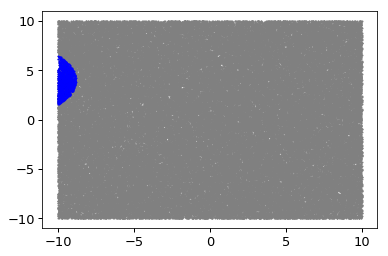

In [4]:
npts = int(1e5)
xpts = np.random.uniform(-10, 10, npts)
ypts = np.random.uniform(-10, 10, npts)

xc, yc = -20, 4
major_axis_angle = 0.
b_by_a = 4.
nkeep = int(1000)

from galsize_models.measurements.ellipse_selection_functions import ellipse_selector 

mask = ellipse_selector(xpts, ypts, xc, yc, major_axis_angle, b_by_a, nkeep)

fig, ax = plt.subplots(1, 1)

__=ax.scatter(xpts, ypts, color='gray', s=1)
__=ax.scatter(xpts[mask], ypts[mask], color='blue', s=1)

In [5]:
def get_percentile_based_bins(arr, nbins, lowp=0.025, highp=0.975):
    """ Calculate a binning scheme for ``arr`` based on its rank-order percentiles. 
    
    Percentile bin spacing is linear between lowp and highp, with 0 and 1 for endpoints. 
    
    Parameters 
    ----------
    arr : ndarray 
        Numpy array of shape (ndata, )
    
    nbins : int
    
    lowp : float, optional

    highp : float, optional

    Returns 
    -------
    arr_bin_edges : ndarray of shape (nbins+1, )
    
    percentile_bin_edges : ndarray of shape (nbins+1, ) 
    """
    sorted_arr = np.sort(arr)
    percentile_bin_edges = np.linspace(lowp, highp, nbins-1)
    percentile_bin_edges = np.insert(np.append(percentile_bin_edges, 1.), 0, 0.)

    percentile_indices = np.floor((len(arr)-1)*percentile_bin_edges).astype(int)
    percentile_indices = np.insert(np.append(percentile_indices, len(arr)-1), 0, 0)
    
    arr_bin_edges = sorted_arr[percentile_indices]
    return arr_bin_edges, percentile_bin_edges

In [51]:
from halotools.utils import monte_carlo_from_cdf_lookup, build_cdf_lookup
sm = mock['sm'].data
ssfr = mock['ssfr'].data
dssfr = 0.25

logsm_bins = np.linspace(9.8, 11.75, 15)
sm_bins = 10**logsm_bins
sm_bins = np.insert(np.append(sm_bins, np.inf), 0, -np.inf)
logsm_bins = np.insert(np.append(logsm_bins, np.inf), 0, -np.inf)

nkeep = 2500

bt_random = np.zeros_like(sm) + np.nan

msg = "Working on sm = {0:.1f}, ssfr = {1:.1f}\nSDSS <sm> = {2:.1f} SDSS <ssfr> = {3:.1f}"

for ism, sm_low, sm_high in zip(range(len(sm_bins)), sm_bins[:-1], sm_bins[1:]):
    ism_mask = (sm >= sm_low) & (sm < sm_high)
    logsm_mid = np.log10(np.median(sm[ism_mask]))
    
    ssfr_bins = get_percentile_based_bins(ssfr[ism_mask], 15)[0]
    for jssfr, ssfr_low, ssfr_high in zip(range(len(ssfr_bins)), ssfr_bins[:-1], ssfr_bins[1:]):
        ssfr_mid = 0.5*(ssfr_low + ssfr_high)

        
        ij_mask = ism_mask & (ssfr >= ssfr_low) & (ssfr < ssfr_high)
        num_ij = np.count_nonzero(ij_mask)
        
        if num_ij > 0:
            mask = ellipse_selector(sdss['sm'], sdss['ssfr'], 
                                    logsm_mid, ssfr_mid, 0., 1., nkeep)
            sdss_bt_ij_sample = sdss['bulge_to_total_rband_meert15'][mask]
            x_table, y_table = build_cdf_lookup(sdss_bt_ij_sample)
            bt_random[ij_mask] = monte_carlo_from_cdf_lookup(x_table, y_table, num_draws=num_ij)
            
#  Fill in the tiny number of unassigned values with random values beween (0, 1)
unassigned_mask = np.isnan(bt_random)
bt_random[unassigned_mask] = np.random.uniform(0, 1, np.count_nonzero(unassigned_mask))


In [52]:
mock['bt'] = bt_random

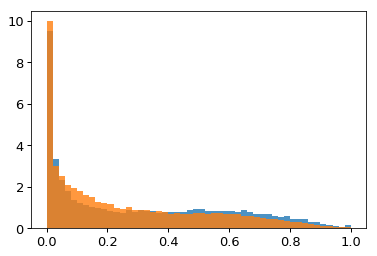

In [61]:
fig, ax = plt.subplots(1, 1)

mock_mask = mock['sm'] < 10**10
__=ax.hist(mock['bt'][mock_mask], bins=50, normed=True, alpha=0.8)
sdss_mask = sdss['sm'] < 10
__=ax.hist(sdss['bulge_to_total_rband_meert15'][sdss_mask], bins=50, normed=True, alpha=0.8)


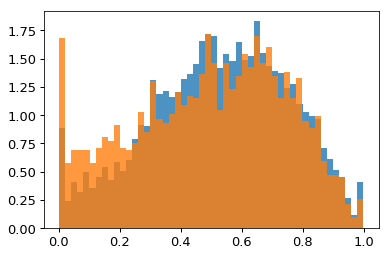

In [64]:
fig, ax = plt.subplots(1, 1)

mock_mask = (mock['sm'] < 10**10) & (mock['sm'] < 10**10.25) & (mock['ssfr'] < -11.5)
sdss_mask = (sdss['sm'] < 10) & (sdss['sm'] < 10.25) & (sdss['ssfr'] < -11.5)

__=ax.hist(mock['bt'][mock_mask], bins=50, normed=True, alpha=0.8)
__=ax.hist(sdss['bulge_to_total_rband_meert15'][sdss_mask], bins=50, normed=True, alpha=0.8)
